<a href="https://colab.research.google.com/github/SergeyShchus/Satellite-Imagery-Analysis-with-Python/blob/master/jupyter-notebooks/detecting-changes/Detecting_Changes_in_Sentinel_1_Imagery_(agro)%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecting Changes in Sentinel-1 Imagery (agro)

---



### Run me first

Run the following cell to initialize the API. The output will contain instructions on how to grant this notebook access to Earth Engine using your account.

In [2]:
import ee

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=k3eE6fZ-oO0rm-VtRtLCTQmKtyzqY3SylLZW1tsX9DA&tc=OG_gGnNNnBgMhIeOXi-LRJ1a2APS0fEVFikSRT7yMrY&cc=sVr4jKKqQdLsp4jfpn07f-j-OWY8VUazbwbsKYO7IPU

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AdQt8qjTf52cnm5sTJm3yDe_kNaBAW2IDfrZsQDlb7noIxi-ei5z2fS8Yis

Successfully saved authorization token.


### Datasets and Python modules
One [dataset](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S1_GRD) will be used in the tutorial:

- COPERNICUS/S1_GRD_FLOAT
    - Sentinel-1 ground range detected images

The following cell imports some python modules which we will be using as we go along and enables inline graphics.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, gamma, f, chi2
import IPython.display as disp
%matplotlib inline

And to make use of interactive graphics, we import the _folium_ package:

In [5]:
# Import the Folium library.
import folium

# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer


### Bivariate change detection

Rather than analyzing the VV and VH bands individually, it would make more sense to treat them together, and that is what we will now do. Again with the aim of keeping the notation simple, define

$$
\pmatrix{ s_i & 0\cr 0 & r_i} = \pmatrix{\langle|S_{vv}|^2\rangle_i & 0 \cr 0 & \langle|S_{vh}|^2\rangle_i}, \quad {\rm with\ means}\quad a_i = \langle|S^{a_i}_{vv}|^2\rangle, \quad b_i = \langle|S^{b_i}_{vh}|^2\rangle \tag{2.13}
$$

for the two acquisition times $t_i,\ i=1,2$. 

Under $H_0$ we have $a_1=a_2=a$ and $b_1=b_2=b$. Assuming independence of $s_i$ and $r_i$, the likelihood function is the product of the four gamma distributions

$$
L_0(a,b) = p(s_1\mid a)p(r_1\mid b)p(s_2\mid a)p(r_2\mid b).
$$

Under $H_1$,

$$
L_1(a_1,b_1,a_2,b_2) = p(s_1\mid a_1)p(r_1\mid b_1)p(s_2\mid a_2)p(r_2\mid b_2).
$$

With maximum likelihood estimates under $H_0$ 

$$
\hat a = (s_1+s_2)/2\quad {\rm and}\quad \hat b = (r_1+r_2)/2
$$ 

for the parameters and some simple algebra, we get 

$$
L_0(\hat a,\hat b) = {(2m)^{4m}\over (s_1+s_2)^{2m}(r_1+r_2)^{2m}\Gamma(m)^4}s_1r_1s_2r_2e^{-4m}. \tag{2.14}
$$ 

Similarly with $\hat a_1=s_1,\ \hat b_1=r_1,\ \hat a_2=s_2,\ \hat b_2=r_2$, we calculate

$$
L_1(\hat a_1,\hat b_1,\hat a_2,\hat b_2) = {m^{4m}\over s_1r_1s_2r_2}e^{-4m}.
$$

The likelihood test statistic in then

$$
Q = {L_0(\hat a,\hat b)\over L_1(\hat a_1,\hat b_1,\hat a_2,\hat b_2)}={2^4(s_1r_1s_2r_2)^m\over (s_1+s_2)^{2m}(r_1+r_2)^{2m}}.
$$

Writing this in terms of the covariance matrix representation,

$$
c_i = \pmatrix{s_i & 0\cr 0 & r_i},\quad i=1,2,
$$

we derive, finally, the likelihood ratio test

$$
Q = \left[2^4\pmatrix{|c_1| |c_2|\over |c_1+c_2|^2 }\right]^m \le k, \tag{2.15}
$$

where $|\cdot|$ indicates the matrix determinant, $|c_i|=s_ir_i$. 

So far so good. But in order to determine _P_ values, we need the probability distribution of $Q$. This time we have no idea how to obtain it. Here again, statistical theory comes to our rescue.

Let $\Theta$ be the parameter space for the LRT. In our example it is 
$$
\Theta = \{ a_1,b_1,a_2,b_2\}
$$ 
and has $d=4$ dimensions. Under the null hypothesis the parameter space is restricted by the conditions $a=a_1=a_2$ and $b=b_1=b_2$ to 
$$
\Theta_0 = \{ a,b\}
$$ 
with $d_0=2$ dimensions. According to [Wilks' Theorem](https://en.wikipedia.org/wiki/Wilks%27_theorem), as the number of measurements determining the LRT statistic $Q$ approaches $\infty$, the test statistic $-2\log Q$ approaches a chi square distribution with $d-d_0=2$ degrees of freedom. (Recall that, in order to determine the matrices $c_1$ and $c_2$, five individual measurements were averaged or multi-looked.) So rather than working with $Q$ directly, we use $-2\log Q$ instead and hope that Wilk's theorem is a good enough approximation for our case.

In order to check if this is so, we just have to program 

$$
-2\log Q = (\log{|c_1|}+\log{|c_2|}-2\log{|c_1+c_2|}+4\log{2})(-2m)
$$ 

in GEE-ese:

In [10]:
geoJSON = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              8.473892211914062,
              49.98081240937428
            ],
            [
              8.658599853515625,
              49.98081240937428
            ],
            [
              8.658599853515625,
              50.06066538593667
            ],
            [
              8.473892211914062,
              50.06066538593667
            ],
            [
              8.473892211914062,
              49.98081240937428
            ]
          ]
        ]
      }
    }
  ]
}
coords = geoJSON['features'][0]['geometry']['coordinates']
aoi = ee.Geometry.Polygon(coords)
geoJSON = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              8.534317016601562,
              50.021637833966786
            ],
            [
              8.530540466308594,
              49.99780882512238
            ],
            [
              8.564186096191406,
              50.00663576154257
            ],
            [
              8.578605651855469,
              50.019431940583104
            ],
            [
              8.534317016601562,
              50.021637833966786
            ]
          ]
        ]
      }
    }
  ]
}
coords = geoJSON['features'][0]['geometry']['coordinates']
aoi_sub = ee.Geometry.Polygon(coords)

In [11]:
im_coll = (ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT')
                .filterBounds(aoi)
                .filterDate(ee.Date('2020-08-01'),ee.Date('2020-08-31'))
                .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))
                .filter(ee.Filter.eq('relativeOrbitNumber_start', 15))
                .sort('system:time_start'))

In [12]:
im_list = im_coll.toList(im_coll.size())
im1 = ee.Image(im_list.get(0)).select('VV').clip(aoi_sub)
im2 = ee.Image(im_list.get(1)).select('VV').clip(aoi_sub)

In [13]:
def det(im):
  return im.expression('b(0) * b(1)')

# Number of looks.
m = 5

im1 = ee.Image(im_list.get(0)).select('VV', 'VH').clip(aoi)
im2 = ee.Image(im_list.get(1)).select('VV', 'VH').clip(aoi)

m2logQ = det(im1).log().add(det(im2).log()).subtract(
    det(im1.add(im2)).log().multiply(2)).add(4*np.log(2)).multiply(-2*m)

and then plot its histogram, comparing it with the chi square distribution scipy.stats.chi2.pdf() with two degrees of freedom:

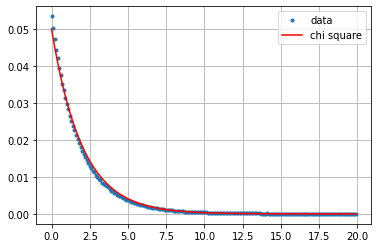

In [14]:
hist = m2logQ.reduceRegion(
    ee.Reducer.fixedHistogram(0, 20, 200), aoi).get('VV').getInfo()
a = np.array(hist)
x = a[:, 0]
y = a[:, 1] / np.sum(a[:, 1])
plt.plot(x, y, '.', label='data')
plt.plot(x, chi2.pdf(x, 2)/10, '-r', label='chi square')
plt.legend()
plt.grid()
plt.show()

Looks pretty good. Note now that a small value of the LRT $Q$ in Eq. (2.15) corresponds to a large value of $-2\log{Q}$. Therefore the _P_ value for a measurement $q$ is now the probability of getting the value $-2\log{q}$
or higher,
$$
P = {\rm Prob}(-2\log{Q} \ge -2\log{q}) = 1 - {\rm Prob}(-2\log{Q} < -2\log{q}).
$$


So let's try out our bivariate change detection procedure, this time on an agricultural scene where we expect to see larger regions of change.

In [15]:
geoJSON ={
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              -98.2122802734375,
              49.769291532628515
            ],
            [
              -98.00559997558594,
              49.769291532628515
            ],
            [
              -98.00559997558594,
              49.88578690918283
            ],
            [
              -98.2122802734375,
              49.88578690918283
            ],
            [
              -98.2122802734375,
              49.769291532628515
            ]
          ]
        ]
      }
    }
  ]
}
coords = geoJSON['features'][0]['geometry']['coordinates']
aoi1 = ee.Geometry.Polygon(coords)

This is a mixed agricultural/forest area in southern Manitoba, Canada. We'll gather two images, one from the beginning of August and one from the beginning of September, 2018. A lot of harvesting takes place in this interval, so we expect some extensive changes.

In [16]:
im1 = ee.Image(ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT')
                .filterBounds(aoi1)
                .filterDate(ee.Date('2018-08-01'), ee.Date('2018-08-31'))
                .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))
                .filter(ee.Filter.eq('relativeOrbitNumber_start', 136))
                .first()
                .clip(aoi1))
im2 = ee.Image(ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT').filterBounds(aoi1)
                .filterDate(ee.Date('2018-09-01'), ee.Date('2018-09-30'))
                .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))
                .filter(ee.Filter.eq('relativeOrbitNumber_start', 136))
                .first()
                .clip(aoi1))

Here are the acquisition times:

In [18]:
import time
acq_time = im1.get('system:time_start').getInfo()
print( time.strftime('%x', time.gmtime(acq_time/1000)) )
acq_time = im2.get('system:time_start').getInfo()
print( time.strftime('%x', time.gmtime(acq_time/1000)) )

08/01/18
09/06/18


acq_time = im1.get('system:time_start').getInfo()
print( time.strftime('%x', time.gmtime(acq_time/1000)) )
acq_time = im2.get('system:time_start').getInfo()
print( time.strftime('%x', time.gmtime(acq_time/1000)) )

In [19]:
def chi2cdf(chi2, df):
  ''' Chi square cumulative distribution function for df degrees of freedom
      using the built-in incomplete gamma function gammainc() '''
  return ee.Image(chi2.divide(2)).gammainc(ee.Number(df).divide(2))

# The observed test statistic image -2logq.
m2logq = det(im1).log().add(det(im2).log()).subtract(
    det(im1.add(im2)).log().multiply(2)).add(4*np.log(2)).multiply(-2*m)

# The P value image prob(m2logQ > m2logq) = 1 - prob(m2logQ < m2logq).
p_value = ee.Image.constant(1).subtract(chi2cdf(m2logq, 2))

# Project onto map.
location = aoi1.centroid().coordinates().getInfo()[::-1]
mp = folium.Map(location=location, zoom_start=12)
mp.add_ee_layer(p_value,
                {'min': 0,'max': 1, 'palette': ['black', 'white']}, 'P-value')
mp.add_child(folium.LayerControl())

The uniformly dark areas correspond to small or vanishing _P_ values and signify change. The bright areas correspond to no change. Why they are not uniformly bright will be explained below. Now we set a significance threshold of $\alpha=0.01$ and display the significant changes, whereby 1% of them will be false positives. For reference we also show the 2018 [Canada AAFC Annual Crop Inventory](https://developers.google.com/earth-engine/datasets/catalog/AAFC_ACI) map, which is available as a GEE collection:

In [20]:
c_map = p_value.multiply(0).where(p_value.lt(0.01), 1)

crop2018 = (ee.ImageCollection('AAFC/ACI')
             .filter(ee.Filter.date('2018-01-01', '2018-12-01'))
             .first()
             .clip(aoi1))

mp = folium.Map(location=location, zoom_start=12)
mp.add_ee_layer(crop2018, {min: 0, max: 255}, 'crop2018')
mp.add_ee_layer(c_map.updateMask(
    c_map.gt(0)), {'min': 0, 'max': 1, 'palette': ['black', 'red']}, 'c_map')
mp.add_child(folium.LayerControl())

 The major crops in the scene are soybeans (dark brown), oats (light brown), canola (light green), corn (light yellow) and winter wheat (dark gray). The wooded areas exhibit little change, while canola has evidently been extensively harvested in the interval.

 #### A note on _P_ values
Because small _P_ values are indicative of change, it is tempting to say that, the larger the _P_ value, the higher the probability of no change. Or more explicitly, the _P_ value is itself the no change probability. Let's see why this is false. Below we choose a wooded area of the agricultural scene where few significant changes are to be expected and use it to subset the _P_ value image. Then we plot the histogram of the subset:

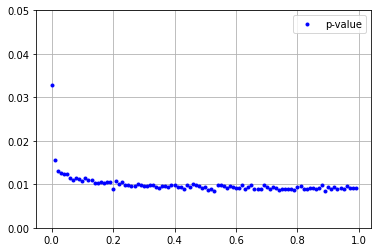

In [21]:
geoJSON ={
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              -98.18550109863281,
              49.769735012247885
            ],
            [
              -98.13949584960938,
              49.769735012247885
            ],
            [
              -98.13949584960938,
              49.798109268622
            ],
            [
              -98.18550109863281,
              49.798109268622
            ],
            [
              -98.18550109863281,
              49.769735012247885
            ]
          ]
        ]
      }
    }
  ]
}
coords = geoJSON['features'][0]['geometry']['coordinates']
aoi1_sub = ee.Geometry.Polygon(coords)
hist = p_value.reduceRegion(ee.Reducer.fixedHistogram(0, 1, 100), aoi1_sub).get('constant').getInfo()
a = np.array(hist)
x = a[:,0]
y = a[:,1]/np.sum(a[:,1])
plt.plot(x, y, '.b', label='p-value')
plt.ylim(0, 0.05)
plt.grid()
plt.legend()
plt.show()

So the P values of no-change measurements are uniformly distributed over  [0,1]  (the excess of small P values at the left can be ascribed to genuine changes within the polygon). A large P value is no more indicative of no change than a small one. Of course it has to be this way. When, for example, we set a significance level of 5%, then the fraction of false positives, i.e., the fraction of P values smaller than 0.05 given  𝐻0 , must also be 5%. This accounts for the noisy appearance of the P value image in the no-change regions.

#### Change direction: the Loewner order
What about the direction of change in the bivariate case? This is less clear, as we can have the situation where the VV intensity gets larger and the VH smaller from time $t_1$ to $t_2$, or vice versa. When we are dealing with the C2 covariance matrix representation of SAR imagery, see Eq. (2.13), a characterization of change can be made as follows [(Nielsen et al. (2019))](https://ieeexplore.ieee.org/document/8736751): For each significantly changed pixel, we determine the difference $C2_{t_2}-C2_{t_1}$ and examine its so-called _definiteness_, also known as the _Loewner order_ of the change. A matrix is said to be _positive definite_ if all of its eigenvalues are positive, _negative definite_ if they are all negative, otherwise _indefinite_. In the case of the $2\times 2$ diagonal matrices that we are concerned with the eigenvalues are just the two diagonal elements themselves, so determining the Loewner order is trivial. For full $2\times 2$ dual pol or $3\times 3$ quad pol SAR imagery, devising an efficient way to determine the Loewner order is more difficult, see [Nielsen (2019)](https://ieeexplore.ieee.org/document/8913617).

So let's include the Loewner order in our change map:

In [22]:
c_map = p_value.multiply(0).where(p_value.lt(0.01), 1)
diff = im2.subtract(im1)
d_map = c_map.multiply(0)                    # Initialize the direction map to zero.
d_map = d_map.where(det(diff).gt(0), 2)      # All pos or neg def diffs are now labeled 2.
d_map = d_map.where(diff.select(0).gt(0), 3) # Re-label pos def (and label some indef) to 3.
d_map = d_map.where(det(diff).lt(0), 1)      # Label all indef to 1.
c_map = c_map.multiply(d_map)                # Re-label the c_map, 0*X = 0, 1*1 = 1, 1*2= 2, 1*3 = 3.

Now we display the changes, with positive definite red, negative definite blue, and indefinite yellow:

In [23]:
mp = folium.Map(location=location, zoom_start=12)
mp.add_ee_layer(crop2018, {min: 0, max: 255}, 'crop2018')
mp.add_ee_layer(
    c_map.updateMask(c_map.gt(0)), {
        'min': 0,
        'max': 3,
        'palette': ['black', 'yellow', 'blue', 'red']
    }, 'c_map')
mp.add_child(folium.LayerControl())

The more or less compact blue changes indicate a decrease in reflectivity in both VV and VH bands, and correspond to crop harvesting (especially canola).